# lab-2

# Підготовка даних
1. Вибір набору даних
    Використайте датасет відповідно вашого варіанту за списком 
підгрупи.
2. Попередня обробка даних
  Перевірити наявність пропущених значень та при необхідності 
обробити їх (видалення, заповнення середнім, медіаною тощо).
  Здійснити масштабування/стандартизацію ознак (наприклад, за 
допомогою StandardScaler або MinMaxScaler).
  Зафіксувати обраний підхід до нормалізації даних та 
обґрунтувати його вибір.

In [1]:
import pandas as pd
import numpy as np

In [2]:
DATA_PATH = '../data/calories.csv'
ds = pd.read_csv(DATA_PATH)
ds = ds.drop(['Calories', 'User_ID'], axis=1)

In [3]:
ds.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,male,68,190.0,94.0,29.0,105.0,40.8
1,female,20,166.0,60.0,14.0,94.0,40.3
2,male,69,179.0,79.0,5.0,88.0,38.7
3,female,34,179.0,71.0,13.0,100.0,40.5
4,female,27,154.0,58.0,10.0,81.0,39.8


In [4]:
ds[['Gender', 'Age']]

,Gender,Age
0,male,68
1,female,20
2,male,69
3,female,34
4,female,27
...,...,...
14995,female,20
14996,female,27
14997,female,43
14998,male,78


In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      15000 non-null  object 
 1   Age         15000 non-null  int64  
 2   Height      15000 non-null  float64
 3   Weight      15000 non-null  float64
 4   Duration    15000 non-null  float64
 5   Heart_Rate  15000 non-null  float64
 6   Body_Temp   15000 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 820.4+ KB


In [6]:
gender_map = {
  'male': 0,
  'female': 1,
}
ds['Gender'] = ds['Gender'].map(gender_map).astype(bool)

In [7]:
ds.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp'],
      dtype='object')

In [8]:
num_cols = [
  'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'
]

In [9]:
X = ds.values

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X_scaled

array([[-1.00709181,  1.48472604,  1.08958204, ...,  1.61912727,
         0.98940395,  0.99402302],
       [ 0.99295813, -1.34217934, -0.59372619, ..., -0.1839901 ,
        -0.15846102,  0.3523425 ],
       [-1.00709181,  1.5436199 ,  0.31806577, ..., -1.26586052,
        -0.78456918, -1.70103518],
       ...,
       [ 0.99295813,  0.01237949, -1.08469109, ...,  0.05642555,
        -0.57586646,  0.09567029],
       [-1.00709181,  2.07366466,  1.29999557, ..., -1.62648399,
        -1.20197462, -2.21437961],
       [-1.00709181,  1.19025673, -0.10276129, ...,  0.2968412 ,
        -0.36716374,  0.60901471]])

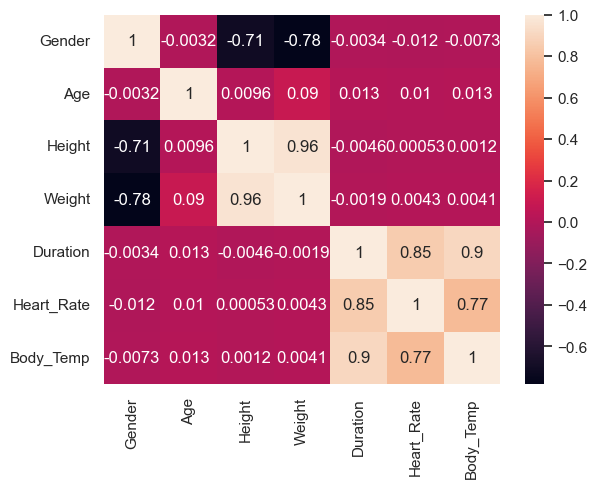

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_map = ds.corr()
sns.set_theme(style="whitegrid", palette="muted", color_codes=True)
sns.heatmap(data=corr_map, annot=True) 
plt.show()

lots of linearly corelated features so I'll go with PCA

# II. Кластеризація у вихідному просторі (без зменшення розмірності)
У цьому блоці порівнюємо роботу кількох алгоритмів кластеризації на 
початкових (вихідних) даних.

In [13]:
n_clusters = 3

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(
  n_clusters=n_clusters,
  random_state=42
)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_labels

array([1, 2, 0, ..., 2, 0, 1])

In [15]:
kmeans_score = silhouette_score(X_scaled, kmeans_labels)
kmeans_score

0.2896308878377891

In [16]:
# ---- Fuzzy C-Means ----
# Для skfuzzy дані потрібно транспонувати (ознаки - рядки)
X_t = X_scaled.T

In [17]:
# Параметри для FCM
m = 2.0  # показник нечіткості
error = 0.005
maxiter = 1000

In [18]:
import skfuzzy as fuzz

cntr, u, u0, d, jm, p, fpc = fuzz._cluster.cmeans(
  X_t, c=n_clusters, m=m, error=error, maxiter=maxiter, init=None, seed=42
)

In [19]:
# Отримання "жорсткого" розбиття: вибір кластера з найбільшою мірою членства
labels_fcm = np.argmax(u, axis=0)
score_fcm = silhouette_score(X_scaled, labels_fcm)
print("Fuzzy C-Means silhouette score:", score_fcm)

Fuzzy C-Means silhouette score: 0.2860303720559382


In [20]:
from sklearn.mixture import GaussianMixture

# ---- Gaussian Mixture Models (GMM) ----
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(X_scaled)
# Отримання м'яких (ймовірнісних) призначень і перетворення їх на "жорсткі"
labels_gmm = gmm.predict(X_scaled)
score_gmm = silhouette_score(X_scaled, labels_gmm)
print("GMM silhouette score:", score_gmm)

GMM silhouette score: 0.24268008931745574


In [21]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1, min_samples=10)
dbscan_labels = dbscan.fit_predict(X=X_scaled)
score_dbscan = silhouette_score(X_scaled, dbscan_labels)
print("DBSCAN silhouette score:", score_dbscan)

DBSCAN silhouette score: 0.2930798550753514


In [22]:
num_of_outlayers = abs(sum([x for x in dbscan_labels if x < 0]))
print(f"Об\'єктів позначених як шум: {num_of_outlayers}")

Об'єктів позначених як шум: 28


у нас 28 викидів. а оскільки вони позначені як -1, то можна просто додати +1 до нашого вектора - і матимемо вже не k, а k+1 кластерів, де один з них - "шумовий". підхід лінивий, але зручніший

In [23]:
dbscan_labels = dbscan_labels + 1

In [24]:
score_dbscan = silhouette_score(X_scaled, dbscan_labels)
print("DBSCAN silhouette score:", score_dbscan)

DBSCAN silhouette score: 0.2930798550753514


# III. Зменшення розмірності за допомогою PCA (до 2-3 компонент)
1. Застосування PCA
o Використати PCA (з бібліотеки scikit-learn) для зменшення 
розмірності даних до 2 або 3 компонент.
o Пояснити, скільки відсотків варіації даних пояснюють обрані 
головні компоненти.
2. Повторна кластеризація
o Повторити крок 2 (K-Means, Fuzzy C-Means, GMM, DBSCAN) на 
даних після зменшення розмірності.
o Обчислити silhouette score (або інші метрики) та порівняти з 
результатами кластеризації у вихідному просторі.

In [25]:
from sklearn.decomposition import PCA

# Зменшення розмірності до 2 компонент за допомогою PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Відсоток поясненої варіації:", pca.explained_variance_ratio_)

# Функція для побудови графіка кластеризації
def plot_clusters(X, labels, title):
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette="viridis", s=60)
  plt.title(title)
  plt.xlabel("Компонента 1")
  plt.ylabel("Компонента 2")
  plt.legend(title="Кластер")
  plt.show()

Відсоток поясненої варіації: [0.38402747 0.37714649]


K-MEANS silhouette score: 0.4077338814107319


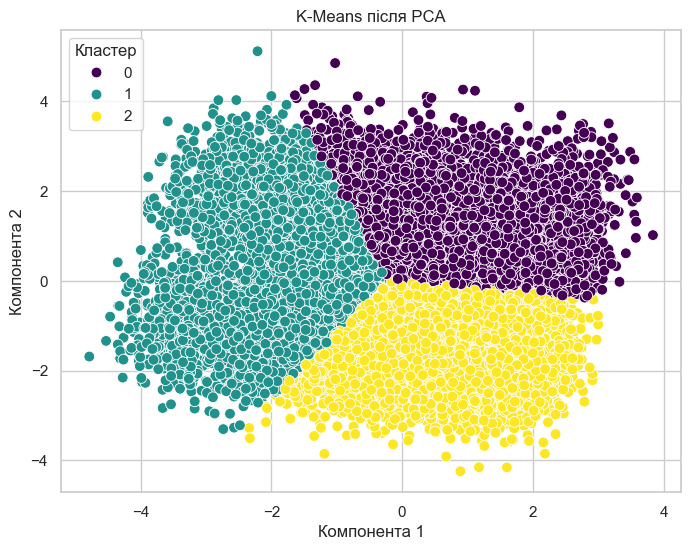

In [26]:
# Побудова графіків для кожного алгоритму
kmeans_labels = kmeans.fit_predict(X_pca)
score_kmeans = silhouette_score(X_pca, kmeans_labels)
print("K-MEANS silhouette score:", score_kmeans)
plot_clusters(X_pca, kmeans_labels, "K-Means після PCA")

Fuzzy-C-means silhouette score: 0.40493263277188246


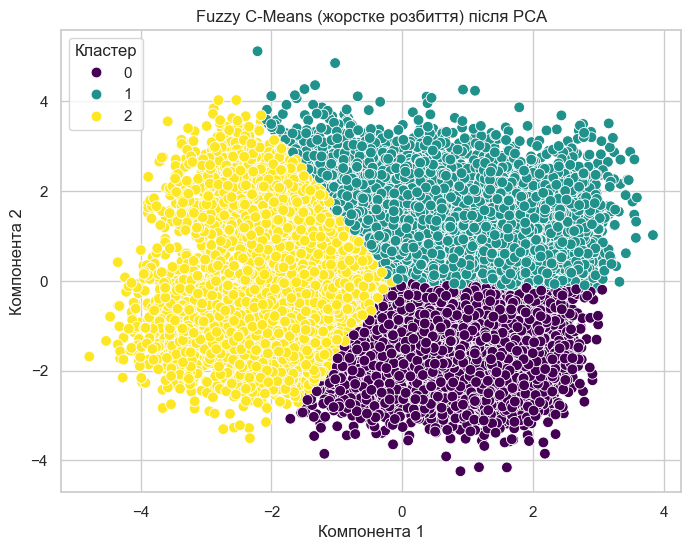

In [27]:
cntr, u, u0, d, jm, p, fpc = fuzz._cluster.cmeans(
  X_pca.T, c=n_clusters, m=m, error=error, maxiter=maxiter, init=None, seed=42
)
labels_fcm = np.argmax(u, axis=0)

score_fcm = silhouette_score(X_pca, labels_fcm)
print("Fuzzy-C-means silhouette score:", score_fcm)

plot_clusters(X_pca, labels_fcm, "Fuzzy C-Means (жорстке розбиття) після PCA")

GMM silhouette score: 0.40563879039845174


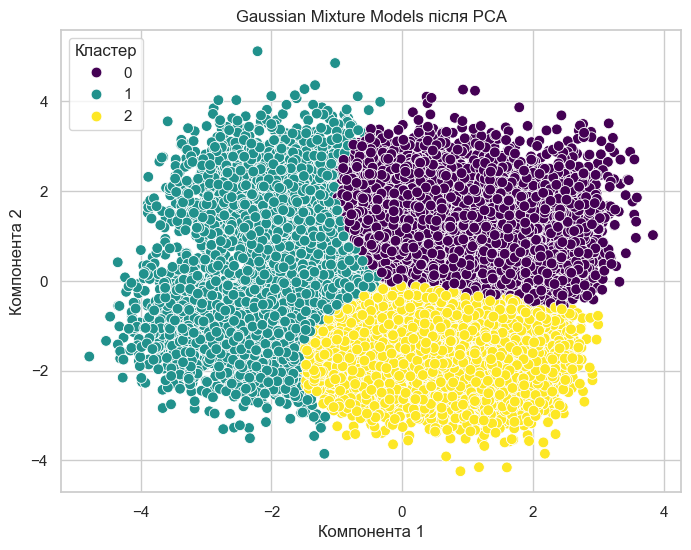

In [28]:
gmm.fit(X_pca)
labels_gmm = gmm.predict(X_pca)

score_gmm = silhouette_score(X_pca, labels_gmm)
print("GMM silhouette score:", score_gmm)

plot_clusters(X_pca, labels_gmm, "Gaussian Mixture Models після PCA")

# IV. Зменшення розмірності за допомогою PCA (до 4-5 компонент)
1. Розширене зменшення розмірності
o Застосувати PCA для зменшення розмірності даних до 4-5 
компонент.
o Порівняти, скільки відсотків варіації тепер пояснюється цими 
компонентами.
2. Кластеризація
o Знову виконати кластеризацію (K-Means, Fuzzy C-Means, GMM, 
DBSCAN) з новими вхідними даними (4-5 компонент).
o Порівняти показники silhouette score та/або інші метрики з 
попередніми результатами.


In [29]:
# Зменшення розмірності до 4 компонент за допомогою PCA
pca = PCA(n_components=4, random_state=42)
X_pca_4 = pca.fit_transform(X_scaled)
print("Відсоток поясненої варіації:", pca.explained_variance_ratio_)

Відсоток поясненої варіації: [0.38402747 0.37714649 0.14318925 0.04641754]


K-MEANS silhouette score: 0.3106770514940969


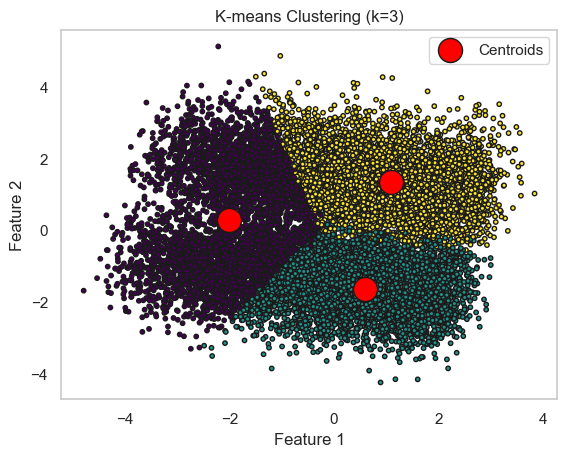

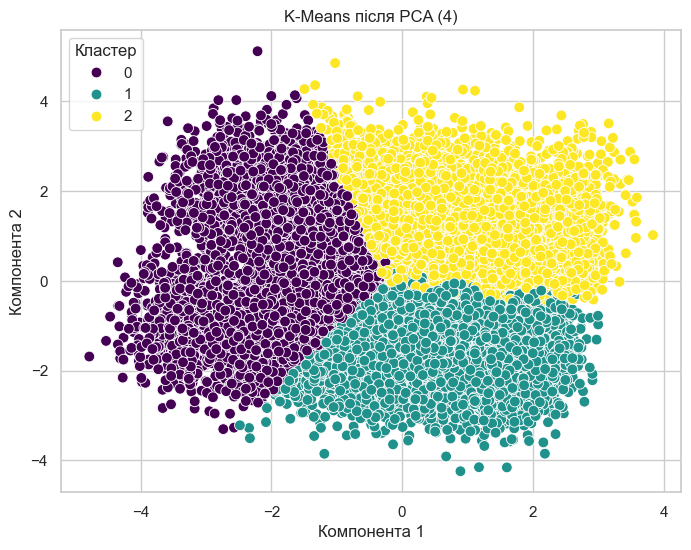

In [30]:
kmeans_labels = kmeans.fit_predict(X_pca_4)
score_kmeans = silhouette_score(X_pca_4, kmeans_labels)
print("K-MEANS silhouette score:", score_kmeans)

# Plot the clustered data points
plt.scatter(X_pca_4[:, 0], X_pca_4[:, 1], c=kmeans_labels, cmap='viridis', edgecolor='k', s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                s=300, c='red', label='Centroids', edgecolor='k')
plt.title(f'K-means Clustering (k={n_clusters})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()

plot_clusters(X_pca_4, kmeans_labels, "K-Means після PCA (4)")


Fuzzy-C-means silhouette score: 0.3071766035598403


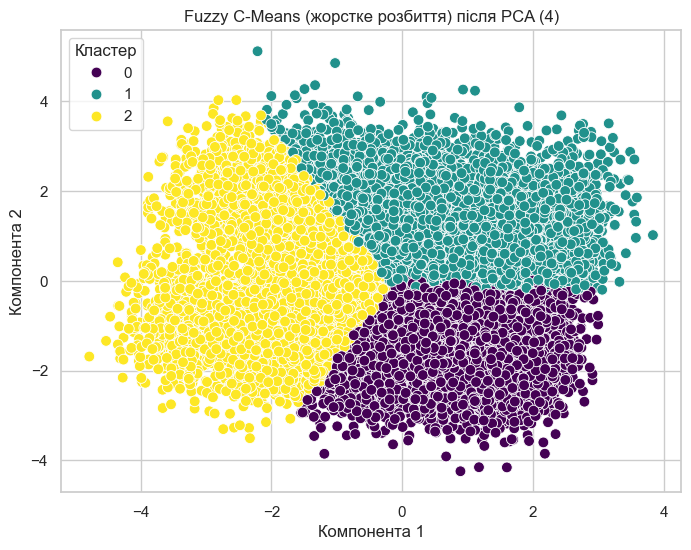

In [31]:
cntr, u, u0, d, jm, p, fpc = fuzz._cluster.cmeans(
  X_pca_4.T, c=n_clusters, m=m, error=error, maxiter=maxiter, init=None, seed=42
)
labels_fcm = np.argmax(u, axis=0)

score_fcm = silhouette_score(X_pca_4, labels_fcm)
print("Fuzzy-C-means silhouette score:", score_fcm)

plot_clusters(X_pca_4, labels_fcm, "Fuzzy C-Means (жорстке розбиття) після PCA (4)")

GMM silhouette score: 0.3087851836273617


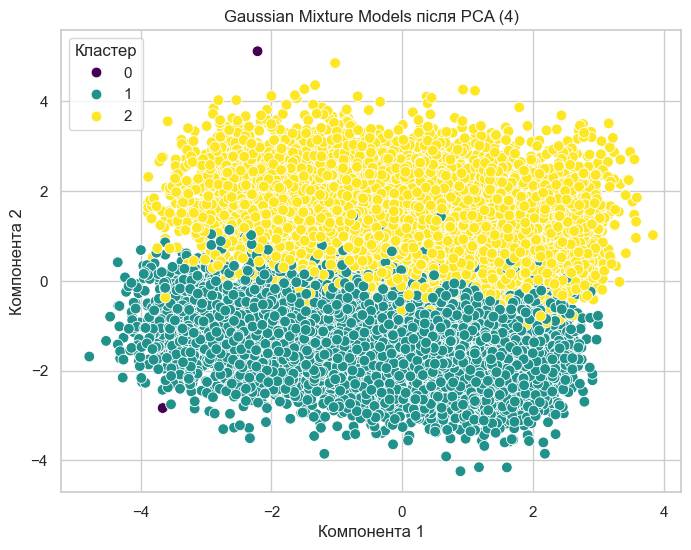

In [33]:
gmm.fit(X_pca_4)
labels_gmm = gmm.predict(X_pca_4)

score_gmm = silhouette_score(X_pca_4, labels_gmm)
print("GMM silhouette score:", score_gmm)

plot_clusters(X_pca_4, labels_gmm, "Gaussian Mixture Models після PCA (4)")

# V. Візуалізація результатів
1. Графічне порівняння
o Побудувати двовимірні чи тривимірні (3D) графіки для наочності 
(залежно від того, чи використовували 2 чи 3 компоненти PCA).
o Для K-Means можна відобразити центри кластерів.
o Для Fuzzy C-Means та GMM — показати ймовірнісні чи нечіткі 
межі (опційно, якщо це можливо та доречно).
2. Зіставлення до та після PCA
o Порівняти результати кластеризації у вихідному просторі (без 
PCA) з результатами після зменшення розмірності (2-3 та 4-5 
компонент).
o Використати кольори, позначки тощо, щоб чітко показати 
відмінності.

# VI. Аналіз та висновки

1. Порівняння показників
o Звести в таблицю показники якості (наприклад, silhouette score, 
Davies-Bouldin index, FPC тощо) для кожного алгоритму у різних 
варіантах:
▪ Без PCA
▪ PCA з 2-3 компонентами
▪ PCA з 4-5 компонентами

## metrics

окрім silhouette score, можна розглянути Calinski-Harabasz 
index, Davies-Bouldin index, Fuzzy Partition Coefficient (FPC), Xie-Beni 
index тощо.

In [34]:
def evaluate_kmeans(X_train, score_fn) -> float:
  kmeans_labels = kmeans.fit_predict(X_train)
  score_kmeans = score_fn(X_pca_4, kmeans_labels)
  return score_kmeans

In [35]:
def evaluate_fcmeans(X_train, score_fn) -> float:
  cntr, u, u0, d, jm, p, fpc = fuzz._cluster.cmeans(
    X_train.T, c=n_clusters, m=m, error=error, maxiter=maxiter, init=None, seed=42
  )
  labels_fcm = np.argmax(u, axis=0)
  score_fcm = score_fn(X_train, labels_fcm)
  return score_fcm

In [36]:
def evaluate_gmm(X_train, score_fn) -> float:
  gmm.fit(X_train)
  labels_gmm = gmm.predict(X_train)
  score_gmm = score_fn(X_train, labels_gmm)
  return score_gmm

In [37]:
evaluators = [
  ("K-means", evaluate_kmeans), 
  ("Fuzzy C-means", evaluate_fcmeans), 
  ("GMM", evaluate_gmm),
]

In [38]:
def compare_methods(score_fn, X_list: list) -> pd.DataFrame:
  score_map = {}
  
  for model_name, model_evaluator in evaluators:
    score_map[model_name] = [model_evaluator(X_train=X_train, score_fn=score_fn) for X_train in X_list]
  
  return pd.DataFrame(score_map).T

In [39]:
pca_2 = PCA(n_components=2, random_state=42)
X_pca_2 = pca_2.fit_transform(X_scaled)
print("Відсоток поясненої варіації (PCA-2):", pca_2.explained_variance_ratio_)

Відсоток поясненої варіації (PCA-2): [0.38402747 0.37714649]


In [40]:
pca_4 = PCA(n_components=4, random_state=42)
X_pca_4 = pca_4.fit_transform(X_scaled)
print("Відсоток поясненої варіації (PCA-4):", pca_4.explained_variance_ratio_)

Відсоток поясненої варіації (PCA-4): [0.38402747 0.37714649 0.14318925 0.04641754]


In [41]:
X_list = [X_scaled, X_pca_2, X_pca_4]
X_list_nmaper = {
  0: "X_scaled", 1: "X_PCA_2", 2: "X_PCA_4",
}

In [42]:
ss_df = compare_methods(silhouette_score, X_list)
ss_df.rename(X_list_nmaper, axis=1)

,X_scaled,X_PCA_2,X_PCA_4
K-means,0.310878,0.308980,0.310677
Fuzzy C-means,0.286030,0.404933,0.307177
GMM,0.242680,0.405639,0.308785


In [43]:
from sklearn.metrics import davies_bouldin_score

davidbldn_df = compare_methods(davies_bouldin_score, X_list)
davidbldn_df.rename(X_list_nmaper, axis=1)

,X_scaled,X_PCA_2,X_PCA_4
K-means,1.103899,1.105853,1.104576
Fuzzy C-means,1.172384,0.842429,1.109935
GMM,1.265200,0.848925,1.837310


In [44]:
from sklearn.metrics import calinski_harabasz_score

calinski_df = compare_methods(calinski_harabasz_score, X_list)
calinski_df.rename(X_list_nmaper, axis=1)

,X_scaled,X_PCA_2,X_PCA_4
K-means,7630.956784,7616.682333,7631.549285
Fuzzy C-means,6859.785043,12450.916163,7557.810667
GMM,3637.383839,12184.223490,3501.575133


## hyperparameters optimization

Для K-Means — метод «лікоть» або silhouette-аналіз для вибору 
кількості кластерів.
o Для GMM — використання BIC, AIC або крос-валідації.
o Для DBSCAN — експериментування з eps та min_samples.


### elbow

In [45]:
from scipy.spatial.distance import cdist
import numpy as np

# Initialize lists to store distortion and inertia values
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

# Fit K-means for different values of k
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
    
    # Calculate distortion as the average squared distance from points to their cluster centers
    distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X.shape[0])
    
    # Inertia is calculated directly by KMeans
    inertias.append(kmeanModel.inertia_)
    
    # Store the mappings for easy access
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

Distortion values:
1 : 48863.36103774338
2 : 43308.48409938555
3 : 42282.15500341017
4 : 42262.382804573455
5 : 40708.107742926186
6 : 40032.11842552219
7 : 38584.340914859386
8 : 38384.287736156024
9 : 38432.79816065891


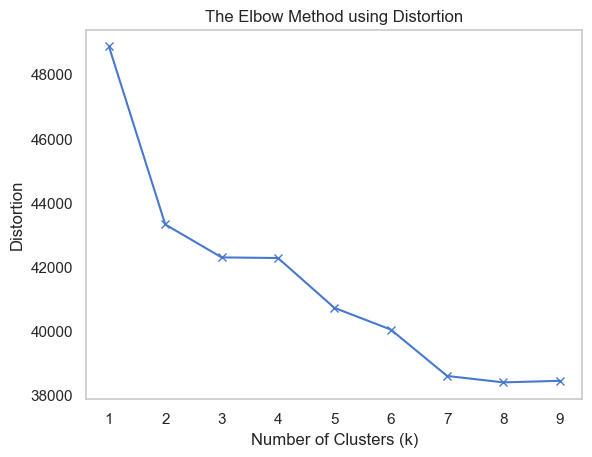

In [46]:
print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')
# Plotting the graph of k versus Distortion
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.grid()
plt.show()

Inertia values:
1 : 13193130.533850664
2 : 8775333.826040706
3 : 6766905.533833422
4 : 5505956.211535543
5 : 4917472.96250985
6 : 4364359.650804126
7 : 4024798.9601497725
8 : 3722493.5952846515
9 : 3464868.735744296


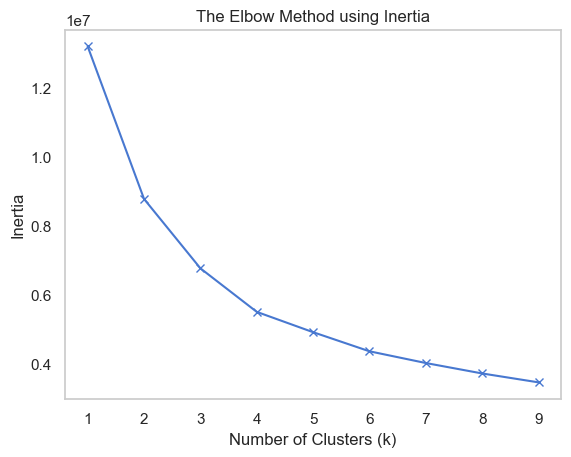

In [47]:
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')
# Plotting the graph of k versus Inertia
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid()
plt.show()

... ?

### BIC